In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string
from scipy.ndimage import gaussian_filter1d

start_date = np.datetime64('2024-09-25 00:00:00')
end_date = np.datetime64('2024-09-28 00:00:00')

# read COAWST model results
# John's Helene hindcast
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

dsm = xr.open_dataset(url)
latm = dsm.lat_rho.values
lonm = dsm.lon_rho.values
time_all = dsm.ocean_time.values
idxms = int( np.where(time_all >= start_date)[0][0] )
idxme = int( np.where(time_all <= end_date)[0][-1] )
timem = time_all[idxms:idxme]
mask_rho = dsm.mask_rho.values
# TODO - change the time of the wet-dry mast
#wd_mask_rho = dsm.wetdry_mask_rho[19,:,:].values
wd_mask_rho = dsm.mask_rho[:,:].values

# Find closest model grid point
# Calculate the difference between the model grid points and the buoy locations; find model indices to closest points
model_shape = np.shape( lonm )
print('model shape: ',model_shape)
print('nlat, nlon: ',np.shape(mask_rho))


model shape:  (512, 833)
nlat, nlon:  (512, 833)


In [2]:
print(dsm)

<xarray.Dataset> Size: 32GB
Dimensions:          (tracer: 2, s_rho: 16, s_w: 17, eta_rho: 512, xi_rho: 833,
                      eta_u: 512, xi_u: 832, eta_v: 511, xi_v: 833,
                      eta_psi: 511, xi_psi: 832, ocean_time: 121)
Coordinates:
  * s_rho            (s_rho) float64 128B -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 136B -1.0 -0.9375 -0.875 ... -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 3MB -87.02 -87.01 ... -78.52
    lat_rho          (eta_rho, xi_rho) float64 3MB 20.85 20.86 ... 35.89 35.9
    lon_u            (eta_u, xi_u) float64 3MB ...
    lat_u            (eta_u, xi_u) float64 3MB ...
    lon_v            (eta_v, xi_v) float64 3MB ...
    lat_v            (eta_v, xi_v) float64 3MB ...
    lon_psi          (eta_psi, xi_psi) float64 3MB ...
    lat_psi          (eta_psi, xi_psi) float64 3MB ...
  * ocean_time       (ocean_time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
Dimensions without coordinates: tracer, e

In [3]:
# Extract the depth, latitude, longitude, and mask (0=land, 1=water)
h = dsm['h'].values
lat = dsm['lat_rho'].values
lon = dsm['lon_rho'].values
mask = wd_mask_rho

Text(0, 0.5, 'Latitude')

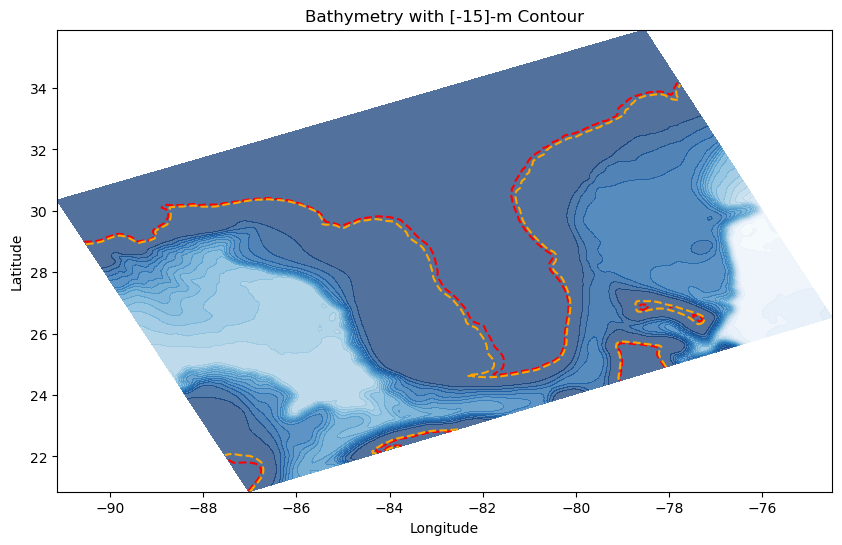

In [4]:
# Plot the depth and  contour
contour_level = [-15 ]
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, -h, levels=20, cmap='Blues', alpha=0.7)
_ = plt.contour(lon, lat, -h, levels=[-10], colors='red')
contour = plt.contour(lon, lat, -h, levels=[-15], colors='orange')
#plt.colorbar(label="Depth (m)")
plt.title(f"Bathymetry with {contour_level}-m Contour")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Contour 0: 2686 points
Mean spacing (km):  3.503061462402989
Gaps:  [[ 138]
 [ 139]
 [ 161]
 [ 162]
 [ 316]
 [ 317]
 [ 521]
 [ 522]
 [2410]
 [2411]]


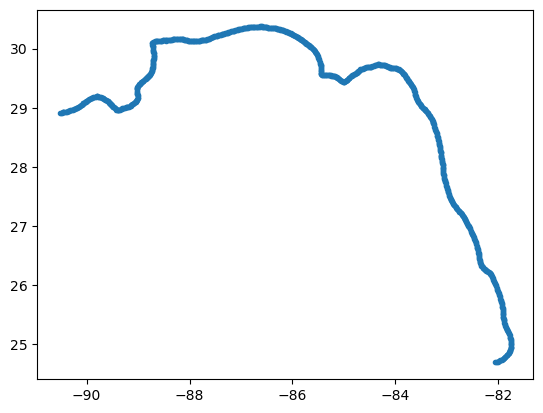

In [25]:
# Extract the vertices from the contour
contour_paths = contour.get_paths()
for i, path in enumerate(contour_paths):
    vertices = path.vertices
    print(f"Contour {i}: {vertices.shape[0]} points")

# Calculate the spacing of the contour point
%run -i storm_coords.py
spacing = [0.]
dlonlat = np.diff(vertices, axis=0)
for i in range(len(dlonlat)-1):
    #print( dlonlat[i][0], dlonlat[i][1], dlonlat[i+1][0], dlonlat[i+1][1], radius=6371.) )
    spacing.append( haversine(dlonlat[i][0], dlonlat[i][1], dlonlat[i+1][0], dlonlat[i+1][1], radius=6371.) )

mean_spacing = np.mean(spacing)
print('Mean spacing (km): ',mean_spacing)
# Find the gaps
print('Gaps: ',np.argwhere(np.array(spacing) >10.))

# After some fiddling, this looks like the region we need
contour15 = vertices[522:1450,:]
plt.plot(contour15[:,0], contour15[:,1],'.')

Tangents (unit): [[ 0.93097118  0.36509267]
 [ 0.93099413  0.36503415]
 [ 0.93103814  0.36492188]
 ...
 [-0.39645812 -0.91805281]
 [-0.39800657 -0.91738256]
 [-0.39874932 -0.91705997]]
Normals (unit): [[ 0.36509267 -0.93097118]
 [ 0.36503415 -0.93099413]
 [ 0.36492188 -0.93103814]
 ...
 [-0.91805281  0.39645812]
 [-0.91738256  0.39800657]
 [-0.91705997  0.39874932]]


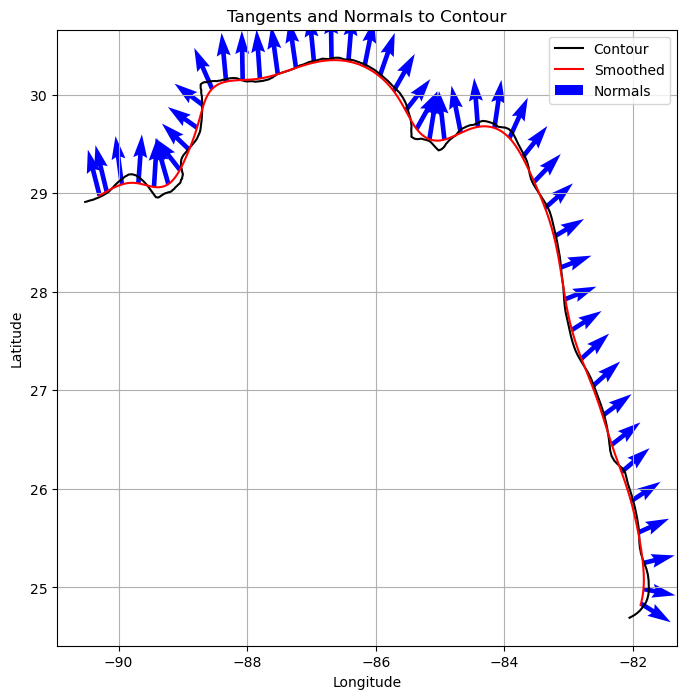

In [7]:
# contour15 is 2d array of longitude, latitudes defining 15-m contour
# Apply Gaussian smoothing to the coordinates
sigma = 20  # Smoothing parameter (higher = smoother)
contour15s = np.column_stack((
    gaussian_filter1d(contour15[:, 0], sigma=sigma),  # Smooth longitude
    gaussian_filter1d(contour15[:, 1], sigma=sigma)   # Smooth latitude
))

# Compute tangents
tangents = np.gradient(contour15s, axis=0)  # Forward/backward difference for each point

# Normalize tangents
tangents_norm = np.linalg.norm(tangents, axis=1, keepdims=True)
tangents_unit = tangents / tangents_norm

# Compute normals
normals = np.zeros_like(tangents)
normals[:, 0] = tangents_unit[:, 1]  # ty -> nx (swap and change sign)
normals[:, 1] = -tangents_unit[:, 0] # -tx -> ny

# Tangents and normals are now arrays of shape (N, 2)
print("Tangents (unit):", tangents_unit)
print("Normals (unit):", normals)

# Visualize tangents and normals
plt.figure(figsize=(8, 8))
plt.plot(contour15[:, 0], contour15[:, 1], 'k-', label='Contour')  # Longitude vs Latitude
plt.plot(contour15s[:, 0], contour15s[:, 1], 'r-', label='Smoothed')  # Longitude vs Latitude
# Plot the tangents
# plt.quiver(
#     contour15s[:, 0], contour15s[:, 1], tangents_unit[:, 0], tangents_unit[:, 1],
#     color='r', angles='xy', scale_units='xy', scale=0.1, label='Tangents'
# )
# Plot the normals, flip the normals by changing signs, plot every 20th
plt.quiver(
    contour15s[::20, 0], contour15s[::20, 1], -normals[::20, 0], -normals[::20, 1],
    color='b', angles='xy', scale_units='xy', scale=2, label='Normals'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Tangents and Normals to Contour')
plt.grid()
plt.show()


In [8]:
import pickle
# Save this data in a pickle file
data_to_save = {
    "contour15": contour15,
    "contour15s": contour15s,
    "tangents": tangents,
    "normals": normals
}

# Save the data to a pickle file
pickle_filename = "contour15_data.pkl"
with open(pickle_filename, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"Data saved to {pickle_filename}")

Data saved to contour15_data.pkl


In [15]:
tangents

array([[ 0.00056762,  0.0002226 ],
       [ 0.00085068,  0.00033355],
       [ 0.00141532,  0.00055474],
       ...,
       [-0.00049872, -0.00115485],
       [-0.00030089, -0.00069354],
       [-0.00020114, -0.0004626 ]])

In [26]:
# Save as a .csv via Pandas
# Create DataFrame
df = pd.DataFrame({
    "contour15s_lon": contour15s[:,0],
    "contour15s_lat": contour15s[:,1],
    "normals_x": -normals[:,0],
    "normals_y": -normals[:,1]
})

# Save to CSV
df.to_csv("contour15.csv", index=False)

print("CSV file saved as contour15.csv")


CSV file saved as contour15.csv


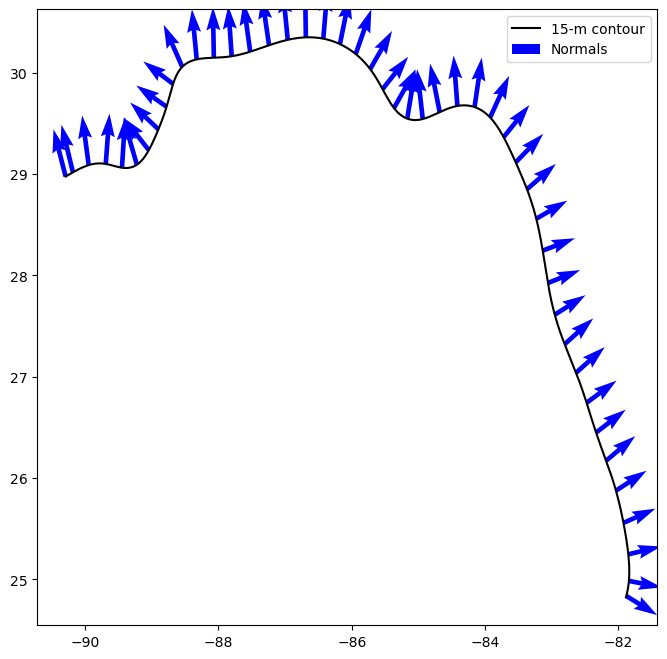

In [38]:
# read and plot the contour points and normals
dsc = pd.read_csv('contour15.csv')

plt.figure(figsize=(8, 8))
plt.plot(dsc['contour15s_lon'], dsc['contour15s_lat'], 'k-', label='15-m contour')  # Longitude vs Latitude

# Plot the normals, flip the normals by changing signs, plot every 20th
plt.quiver(
    dsc['contour15s_lon'][::20], dsc['contour15s_lat'][::20], dsc['normals_x'][::20], dsc['normals_y'][::20],
    color='b', angles='xy', scale_units='xy', scale=2, label='Normals')
plt.legend()
plt.savefig('contour15.png')